In [53]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [54]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [55]:
%cd /'gdrive'/'My Drive'

/gdrive/My Drive


In [56]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torch.optim as optim
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import time
import random
import torch.nn.functional as F

In [57]:
def weights_init(m):
    """
    Initialise weights of the model.
    """
    if(type(m) == nn.ConvTranspose2d or type(m) == nn.Conv2d):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif(type(m) == nn.BatchNorm2d):
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

class NormalNLLLoss:
    """
    Calculate the negative log likelihood
    of normal distribution.
    This needs to be minimised.
    Treating Q(cj | x) as a factored Gaussian.
    """
    def __call__(self, x, mu, var):
        
        logli = -0.5 * (var.mul(2 * np.pi) + 1e-6).log() - (x - mu).pow(2).div(var.mul(2.0) + 1e-6)
        nll = -(logli.sum(1).mean())

        return nll

def noise_sample(n_dis_c, dis_c_dim, n_con_c, n_z, batch_size, device):
    """
    Sample random noise vector for training.
    INPUT
    --------
    n_dis_c : Number of discrete latent code.
    dis_c_dim : Dimension of discrete latent code.
    n_con_c : Number of continuous latent code.
    n_z : Dimension of iicompressible noise.
    batch_size : Batch Size
    device : GPU/CPU
    """

    z = torch.randn(batch_size, n_z, 1, 1, device=device)

    idx = np.zeros((n_dis_c, batch_size))
    if(n_dis_c != 0):
        dis_c = torch.zeros(batch_size, n_dis_c, dis_c_dim, device=device)
        
        for i in range(n_dis_c):
            idx[i] = np.random.randint(dis_c_dim, size=batch_size)
            dis_c[torch.arange(0, batch_size), i, idx[i]] = 1.0

        dis_c = dis_c.view(batch_size, -1, 1, 1)

    if(n_con_c != 0):
        # Random uniform between -1 and 1.
        con_c = torch.rand(batch_size, n_con_c, 1, 1, device=device) * 2 - 1

    noise = z
    if(n_dis_c != 0):
        noise = torch.cat((z, dis_c), dim=1)
    if(n_con_c != 0):
        noise = torch.cat((noise, con_c), dim=1)

    return noise, idx

#Important components in the network

In [58]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        self.tconv1 = nn.ConvTranspose2d(74, 1024, 1, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(1024)

        self.tconv2 = nn.ConvTranspose2d(1024, 128, 7, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(128)

        self.tconv3 = nn.ConvTranspose2d(128, 64, 4, 2, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(64)

        self.tconv4 = nn.ConvTranspose2d(64, 1, 4, 2, padding=1, bias=False)

    def forward(self, x):
        x = F.relu(self.bn1(self.tconv1(x)))
        x = F.relu(self.bn2(self.tconv2(x)))
        x = F.relu(self.bn3(self.tconv3(x)))

        img = torch.sigmoid(self.tconv4(x))

        return img

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 64, 4, 2, 1)

        self.conv2 = nn.Conv2d(64, 128, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(128)

        self.conv3 = nn.Conv2d(128, 1024, 7, bias=False)
        self.bn3 = nn.BatchNorm2d(1024)

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), 0.1, inplace=True)
        x = F.leaky_relu(self.bn2(self.conv2(x)), 0.1, inplace=True)
        x = F.leaky_relu(self.bn3(self.conv3(x)), 0.1, inplace=True)

        return x

class DHead(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv = nn.Conv2d(1024, 1, 1)

    def forward(self, x):
        output = torch.sigmoid(self.conv(x))

        return output

class QHead(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(1024, 128, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(128)

        self.conv_disc = nn.Conv2d(128, 10, 1)
        self.conv_mu = nn.Conv2d(128, 2, 1)
        self.conv_var = nn.Conv2d(128, 2, 1)

    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.conv1(x)), 0.1, inplace=True)

        disc_logits = self.conv_disc(x).squeeze()

        mu = self.conv_mu(x).squeeze()
        var = torch.exp(self.conv_var(x).squeeze())

        return disc_logits, mu, var

# Hyperparameters

In [59]:
params = {
    'batch_size': 128,# Batch size.
    'num_epochs': 10,# Number of epochs to train for.
    'learning_rate': 2e-4,# Learning rate.
    'beta1': 0.5,
    'beta2': 0.999,
    'save_epoch' : 25,# After how many epochs to save checkpoints and generate test output.
    'dataset' : 'MNIST'}
params['num_z'] = 62
params['num_dis_c'] = 1
params['dis_c_dim'] = 10
params['num_con_c'] = 2

# Loading data

In [60]:
transform = transforms.Compose([
    transforms.Resize(28),
    transforms.CenterCrop(28),
    transforms.ToTensor()])

dataset = dsets.MNIST('./', train='train', 
                        download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, 
                                            batch_size=params['batch_size'], 
                                            shuffle=True)

In [61]:
device = torch.device("cuda:0" if(torch.cuda.is_available()) else "cpu")
print(device, " will be used.\n")

cuda:0  will be used.



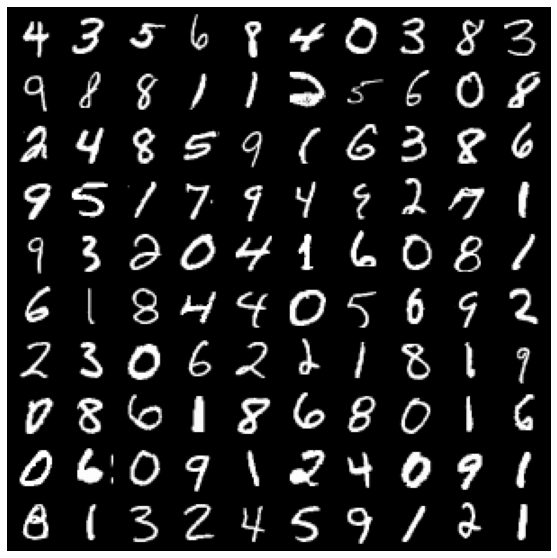

In [62]:
sample_batch = next(iter(dataloader))
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(
    sample_batch[0].to(device)[ : 100], nrow=10, padding=2, normalize=True).cpu(), (1, 2, 0)))

# Initializing the generator

In [63]:
netG = Generator().to(device)
netG.apply(weights_init)
print(netG)

Generator(
  (tconv1): ConvTranspose2d(74, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv2): ConvTranspose2d(1024, 128, kernel_size=(7, 7), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv4): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
)


# Initializing the discriminator

In [64]:
discriminator = Discriminator().to(device)
discriminator.apply(weights_init)
print(discriminator)

Discriminator(
  (conv1): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 1024, kernel_size=(7, 7), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [65]:
netD = DHead().to(device)
netD.apply(weights_init)
print(netD)

DHead(
  (conv): Conv2d(1024, 1, kernel_size=(1, 1), stride=(1, 1))
)


In [66]:
netQ = QHead().to(device)
netQ.apply(weights_init)
print(netQ)

QHead(
  (conv1): Conv2d(1024, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_disc): Conv2d(128, 10, kernel_size=(1, 1), stride=(1, 1))
  (conv_mu): Conv2d(128, 2, kernel_size=(1, 1), stride=(1, 1))
  (conv_var): Conv2d(128, 2, kernel_size=(1, 1), stride=(1, 1))
)


In [67]:
# Loss for discrimination between real and fake images.
criterionD = nn.BCELoss()
criterionQ_dis = nn.CrossEntropyLoss()
criterionQ_con = NormalNLLLoss()
optimD = optim.Adam([{'params': discriminator.parameters()}, {'params': netD.parameters()}], lr=params['learning_rate'], betas=(params['beta1'], params['beta2']))
optimG = optim.Adam([{'params': netG.parameters()}, {'params': netQ.parameters()}], lr=params['learning_rate'], betas=(params['beta1'], params['beta2']))

# Training

In [68]:
z = torch.randn(100, params['num_z'], 1, 1, device=device) #creating z vector in the latent
fixed_noise = z
if (params['num_dis_c'] != 0): #creating the discrete latent unit
    idx = np.arange(params['dis_c_dim']).repeat(10)
    dis_c = torch.zeros(100, params['num_dis_c'], params['dis_c_dim'], device=device)
    for i in range(params['num_dis_c']):
        dis_c[torch.arange(0, 100), i, idx] = 1.0

    dis_c = dis_c.view(100, -1, 1, 1)

    fixed_noise = torch.cat((fixed_noise, dis_c), dim=1)

if(params['num_con_c'] != 0):
    con_c = torch.rand(100, params['num_con_c'], 1, 1, device=device) * 2 - 1
    fixed_noise = torch.cat((fixed_noise, con_c), dim=1)

real_label = 1
fake_label = 0

img_list = []
G_losses = []
D_losses = []

print("-"*25)
print("Starting Training Loop...\n")
print('Epochs: %d\nDataset: {}\nBatch Size: %d\nLength of Data Loader: %d'.format(params['dataset']) % (params['num_epochs'], params['batch_size'], len(dataloader)))
print("-"*25)

start_time = time.time()
iters = 0

for epoch in range(params['num_epochs']):
    epoch_start_time = time.time()

    for i, (data, _) in enumerate(dataloader, 0):
        # Get batch size
        b_size = data.size(0)
        # Transfer data tensor to GPU/CPU (device)
        real_data = data.to(device)

        # Updating discriminator and DHead
        optimD.zero_grad()
        # Real data
        label = torch.full((b_size, ), real_label, device=device, dtype=torch.float32 )
        output1 = discriminator(real_data)
        probs_real = netD(output1).view(-1)
        # print(probs_real.dtype,"++++++++++++++", label.dtype)
        loss_real = criterionD(probs_real, label)
        # Calculate gradients.
        loss_real.backward()

        # Fake data
        label.fill_(fake_label)
        noise, idx = noise_sample(params['num_dis_c'], params['dis_c_dim'], params['num_con_c'], params['num_z'], b_size, device)
        fake_data = netG(noise)
        output2 = discriminator(fake_data.detach())
        probs_fake = netD(output2).view(-1)
        loss_fake = criterionD(probs_fake, label)
        # Calculate gradients.
        loss_fake.backward()

        # Net Loss for the discriminator
        D_loss = loss_real + loss_fake
        # Update parameters
        optimD.step()

        # Updating Generator and QHead
        optimG.zero_grad()

        # Fake data treated as real.
        output = discriminator(fake_data)
        label.fill_(real_label)
        probs_fake = netD(output).view(-1)
        gen_loss = criterionD(probs_fake, label)

        q_logits, q_mu, q_var = netQ(output)
        target = torch.LongTensor(idx).to(device)
        # Calculating loss for discrete latent code.
        dis_loss = 0
        for j in range(params['num_dis_c']):
            dis_loss += criterionQ_dis(q_logits[:, j*10 : j*10 + 10], target[j])

        # Calculating loss for continuous latent code.
        con_loss = 0
        if (params['num_con_c'] != 0):
            con_loss = criterionQ_con(noise[:, params['num_z']+ params['num_dis_c']*params['dis_c_dim'] : ].view(-1, params['num_con_c']), q_mu, q_var)*0.1

        # Net loss for generator.
        G_loss = gen_loss + dis_loss + con_loss
        # Calculate gradients.
        G_loss.backward()
        # Update parameters.
        optimG.step()

        # Check progress of training.
        if i != 0 and i%100 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'
                  % (epoch+1, params['num_epochs'], i, len(dataloader), 
                    D_loss.item(), G_loss.item()))

        # Save the losses for plotting.
        G_losses.append(G_loss.item())
        D_losses.append(D_loss.item())

        iters += 1

    epoch_time = time.time() - epoch_start_time
    print("Time taken for Epoch %d: %.2fs" %(epoch + 1, epoch_time))
    with torch.no_grad():
        gen_data = netG(fixed_noise).detach().cpu()
    img_list.append(vutils.make_grid(gen_data, nrow=10, padding=2, normalize=True))

    # Generate image to check performance of generator.
    if((epoch+1) == 1 or (epoch+1) == params['num_epochs']/2):
        with torch.no_grad():
            gen_data = netG(fixed_noise).detach().cpu()
        plt.figure(figsize=(10, 10))
        plt.axis("off")
        plt.imshow(np.transpose(vutils.make_grid(gen_data, nrow=10, padding=2, normalize=True), (1,2,0)))
        plt.savefig("Epoch_%d {}".format(params['dataset']) %(epoch+1))
        plt.close('all')

training_time = time.time() - start_time
print("-"*50)
print('Training finished!\nTotal Time for Training: %.2fm' %(training_time / 60))
print("-"*50)

-------------------------
Starting Training Loop...

Epochs: 10
Dataset: MNIST
Batch Size: 128
Length of Data Loader: 469
-------------------------
[1/10][100/469]	Loss_D: 0.7424	Loss_G: 1.9399
[1/10][200/469]	Loss_D: 0.6039	Loss_G: 2.2982
[1/10][300/469]	Loss_D: 0.3625	Loss_G: 2.3514
[1/10][400/469]	Loss_D: 0.5204	Loss_G: 2.4526
Time taken for Epoch 1: 81.74s
[2/10][100/469]	Loss_D: 0.6372	Loss_G: 2.2200
[2/10][200/469]	Loss_D: 0.6155	Loss_G: 1.9399
[2/10][300/469]	Loss_D: 0.7481	Loss_G: 1.5867
[2/10][400/469]	Loss_D: 0.8323	Loss_G: 1.5811
Time taken for Epoch 2: 81.21s
[3/10][100/469]	Loss_D: 0.9028	Loss_G: 1.3677
[3/10][200/469]	Loss_D: 0.9084	Loss_G: 1.3572
[3/10][300/469]	Loss_D: 1.1175	Loss_G: 1.1743
[3/10][400/469]	Loss_D: 1.1252	Loss_G: 1.3358
Time taken for Epoch 3: 80.99s
[4/10][100/469]	Loss_D: 1.0543	Loss_G: 1.2154
[4/10][200/469]	Loss_D: 0.9611	Loss_G: 1.4284
[4/10][300/469]	Loss_D: 1.0437	Loss_G: 1.3575
[4/10][400/469]	Loss_D: 1.1244	Loss_G: 1.3190
Time taken for Epoch 4:

In [69]:
%mkdir 'infogan_model'

mkdir: cannot create directory ‘infogan_model’: File exists


In [70]:
# n_samples = 10
# def traversal(z_, dim, minus_x=0, plus_x=0.4, device = 'cpu'):
#   traversals = torch.Tensor(np.linspace(minus_x, plus_x, num = n_samples, dtype=np.float32)).to(device)
#   z = z_.clone()
#   z = z.repeat(n_samples,1,1,1)
#   # z_a = []
#   z[np.arange(n_samples), dim] = traversals.view(-1,1,1)
#   # for i in range(n_samples):
#   #   # print(z.size())
#   #   # z_a.append(z[i].clone())
#   #   # z_a[i][dim] = traversals[i]
#   #   z[i, dim,:,:]= traversals[i]
#   # z = torch.stack(z_a, dim=0)
#   return z

In [71]:
%cd 'infogan_model'
%mkdir 'checkpoint'
%cd 'checkpoint'

/gdrive/My Drive/infogan_model
mkdir: cannot create directory ‘checkpoint’: File exists
/gdrive/My Drive/infogan_model/checkpoint


In [72]:
torch.save({
    'netG' : netG.state_dict(),
    'discriminator' : discriminator.state_dict(),
    'netD' : netD.state_dict(),
    'netQ' : netQ.state_dict(),
    'optimD' : optimD.state_dict(),
    'optimG' : optimG.state_dict(),
    'params' : params
    }, 'checkpoint')

# Code for Traversal

We vary the given dimension 'dim' between minus_x and plus_x and create a tensor which captures all these possible tensors obtained by varying the given dimension. So effectively
INPUT
--------
1. z_ : latent representation to be traversed- size = (1, 74, 1, 1)
2. dim : Dimension along which the traversal has to be done- integer between 0 through 73 in this notebook
3. Minus_x : left extreme of the traversal- default= -1
4. plus_x : right extreme of the traversal- default= +1

OUTPUT
--------
return size: (10, 74, 1, 1)


In [74]:
n_samples = 10
def traversal2(z_, dim, minus_x=-1, plus_x=1):
  traversals = np.linspace(minus_x, plus_x, num = n_samples, dtype=np.float32)
  z = z_.copy()
  z = np.repeat(z, n_samples, axis=0)
  for i in range(n_samples):
    z[i, dim,:,:]= traversals[i]
  return z  

## Traversal on the digits

The latent representation has 2 components: z, c. c further has 2 components: a discrete unit c1 and a continuous c2. c captures the disentangled factors governing the style of the generated samples. In simple terms, by keeping c2, z fixed and generating images obtained by varying c1, we expect to see a change in a single factor which is distributed discretely. In the below example, by varying c1 we notice that only the label of the number generated is changing keeping all the other factors unaffected as the label of a number is a discrete random variable.  

1. In the below example we have that size of z = 62  and is referred to as z1 in the below code. size of c = 12.
2. c has 2 components as mentioned earlier. c1 representing the discrete factor is of size 10(as there are 10 classes in our data) and is represented by the onehot reperesentation of the numbers we intend to generate. The last 2 units correspond to c2 which are continuous factors
3. By keeping z and c2 fixed, only z1 is varied and correspoding images are generated by the generator. It's clear from the images that only the label is changing while keeping the style constant. One thing we need to be careful about is that: the onehot representation (0,0,1,0,0,0,0,0,0,0) might not always represent the number 2 according to the network. The network just learns to assign one fixed number/ label to (0,0,1,0,0,0,0,0,0,0). For example: in the below images, the network assigned (0,0,0,0,0,0,0,0,0,1) to the number 5.

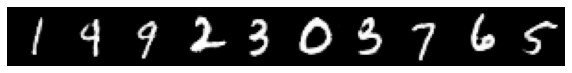

In [75]:
netG.eval()
z1 = np.repeat(np.random.randn(1, params['num_z'], 1, 1), 10, axis=0) # latent variable representing z
fixed_noise = z1
if (params['num_dis_c'] != 0):
  idx = np.arange(params['dis_c_dim'])
  dis_c = np.zeros([10, params['num_dis_c'], params['dis_c_dim']], dtype=np.float32)
  for i in range(params['num_dis_c']):
      dis_c[np.arange(0, 10), i, idx] = 1.0
  dis_c = dis_c.reshape(10, -1, 1, 1)
  fixed_noise = np.concatenate((fixed_noise, dis_c), axis=1)

if (params['num_con_c'] != 0):
  con_c = np.repeat((np.random.uniform(0, 1, [1, params['num_con_c'], 1, 1]) * 2 - 1), 10, axis=0)
  fixed_noise = np.concatenate((fixed_noise, con_c), axis=1)
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(netG(torch.Tensor(fixed_noise).to(device)).detach().cpu(), nrow=n_samples, padding=2, normalize=True), (1,2,0)))

## Traversing the continuous factors
We intend to see what the network learns for each of the continuous units in c2. So,for every possible label, we vary the first unit between -1 and 1 while keeping all the other units constant and see what the network generates. Likewise, we do the same for c2: for every possible label(c1), we vary the second latent unit between -1 and 1 and see the samples generated.  We first create the tensor which has a fixed tensor for every label(c1). 
1.   A random sample z1 is sampled from standard normal distribution of size (1,62,1,1) 
2.   z1 is repeated 10 times along axis=0 making it into size=(10,62,1,1) 
3.   one-hot vectors for the digits 0-9 are created and they're concatenated with z1 along axis=1
4.   2 continuous factors are sampled from uniform distribution and concatenated with z1 by repeating these 2 factors 10 times along axis=0.



In [76]:
netG.eval()
z1 = np.repeat(np.random.randn(1, params['num_z'], 1, 1), 10, axis=0) # latent variable representing z
fixed_noise = z1
if (params['num_dis_c'] != 0):
  idx = np.arange(params['dis_c_dim'])
  dis_c = np.zeros([10, params['num_dis_c'], params['dis_c_dim']], dtype=np.float32)
  for i in range(params['num_dis_c']):
      dis_c[np.arange(0, 10), i, idx] = 1.0
  dis_c = dis_c.reshape(10, -1, 1, 1)
  fixed_noise = np.concatenate((fixed_noise, dis_c), axis=1)

if (params['num_con_c'] != 0):
  con_c = np.repeat((np.random.uniform(0, 1, [1, params['num_con_c'], 1, 1]) * 2 - 1), 10, axis=0)
  fixed_noise = np.concatenate((fixed_noise, con_c), axis=1)

dim_cont_1 = [] #list for holding the traversals of digit 72
dim_cont_2 = [] #list for holding the traversals of digit 73
for i in range(10): #traversal for each digit i
  z = fixed_noise[i].copy().reshape(1,-1,1,1)
  trav_1 = traversal2(z, 72)
  trav_2 = traversal2(z, 73)
  dim_cont_1.append(netG(torch.Tensor(trav_1).to(device)).detach().cpu())
  dim_cont_2.append(netG(torch.Tensor(trav_2).to(device)).detach().cpu())
dim_cont_1 = torch.cat(dim_cont_1, dim=0)
dim_cont_2 = torch.cat(dim_cont_2, dim=0)

# Rotation of numbers

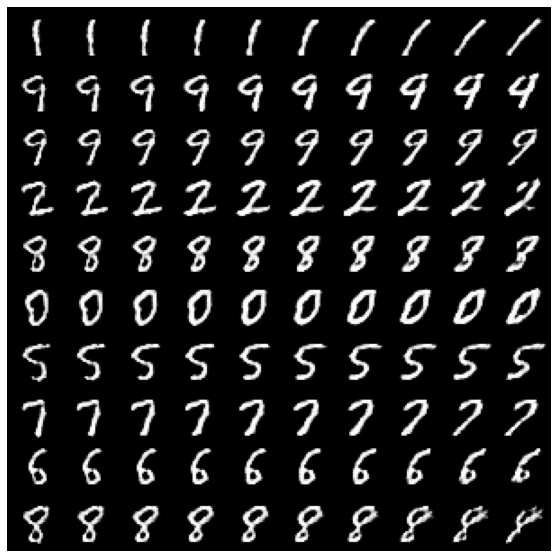

In [77]:
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(dim_cont_2, nrow=n_samples, padding=2, normalize=True), (1,2,0)))

##Thickness of numbers

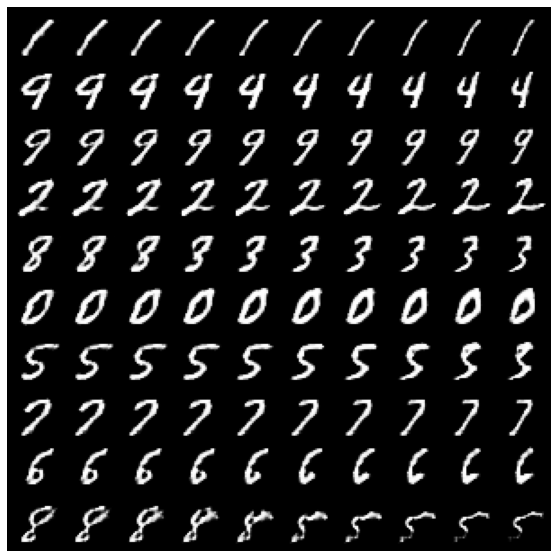

In [78]:
plt.figure(figsize=(10, 10))
plt.axis("off")
# print(fixed_noise[2,:,:,:].size())
plt.imshow(np.transpose(vutils.make_grid(dim_cont_1, nrow=n_samples, padding=2, normalize=True), (1,2,0)))